# <font color='green'>Running faster circuit simulations</font>

So far, you have learned about bit-flip and phase-flip repetition codes. In the process, you have also seen how these error-correcting codes perform by simulating their behavior -- to do this, you ran quantum circuits containing different amounts of errors, and observed how the codes perform under these settings.

For bit-flip repetition codes, we ran our quantum circuits with up to 1 million repetitions, and were able to see logical error probabilities of order 1 in 1 million. You saw that running 1 million shots/repetitions took about a second. On the other hand, for phase-flip repetition codes, where we needed to create a new quantum circuit for each instance of the code with varying levels of noise, it took about 30 seconds to collect statistics by running 50000 circuits.

The reason for the significant slowdown in the phase-flip setting is related to the need for tracking where we inserted errors -- we needed to do this in order to determine when our decoded syndromes were successfully predictive of these locations. Because each circuit contains a different instance of noise on some subset of the data qubits, our general execution structure was

```
for each distance
    for each physical qubit error level
        for 50000 shots
            create 1 random instance of the circuit, record where errors were inserted
            run that circuit
            decode the syndrome measurements
            determine whether a logical error happened (decoded error locations ?= inserted error locations), if so add to count         
```

In contrast, in the bit-flip case, our execution structure was
```
for each distance
    for each physical qubit error level
        create one instance of the circuit containing probabilistic error gates
        run that circuit 1000000 times
        decode the syndrome measurements
        for each shot:
            determine whether a logical error happened (decoded error locations ?= inserted error locations), if so add to count       
```

Note that we are taking full advantage of the Clifford simulation capability of `cirq` when we run the same circuit 1 million times in the bit-flip case, but lose that benefit when we run 1 circuit each time in the phase-flip case.

In this notebook, we will dramatically improve the execution speed of the phase-flip repetition code, reducing it from 26 seconds for 50000 shots to 4 seconds for 1 billion shots. In the process, you will see some of the techniques that the standard tools of QEC employ to run these simulations quickly.

## <font color='blue'>0. Starting point</font>

We will demonstrate a number of techniques for speeding up the simulations of the performance of our phase-flip repetition codes. These techniques are generally applicable, and are routinely used in quantum error correction research. 

Our starting point is reproduced below, with just the necessary parts. Note that we have moved most of the functionality that we built for phase-flip repetition codes into a separate `.py` file that can be imported. We run it again to record the timing results.

In [1]:
from math import floor, comb
import numpy as np
import matplotlib.pyplot as plotter, matplotlib.cm as cm
import cirq
from myMWPM import MWPMDecoder1D
from tqdm import tqdm
from collections import Counter
from itertools import combinations

from phase_flip_rep_codes import   \
                    get_binary_representation,\
                    create_repetition_code_encoder,\
                    get_syndrome_measurement,\
                    create_full_repetition_code_circuit,\
                    get_logical_error_probability_analytical,\
                    get_logical_error_probability_for_rep_code,\
                    plot_logical_error_probabilities

In [2]:
logical_state = '+'; repcode_type = 'X'; error_gate = cirq.Z
distances = [3]
physical_errors = np.logspace(-3, 0, 10)
n_shots = 50000

all_logical_errors = []
for distance in distances:        
    print(f"Running distance {distance}, {repcode_type}-type rep code, initialized as |{logical_state}>_L, error_gate {error_gate}")
    thisdistance_logicalerrors = []
    for error_probability in tqdm(physical_errors):
        logical_error_probability = get_logical_error_probability_for_rep_code(n_qubits = distance, error_probability = error_probability, n_shots = n_shots, 
                                                                               logical_state = logical_state, repcode_type = repcode_type, error_gate = error_gate
                                                                            )
        thisdistance_logicalerrors.append(logical_error_probability)
    all_logical_errors.append(thisdistance_logicalerrors)

Running distance 3, X-type rep code, initialized as |+>_L, error_gate Z


100%|████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:47<00:00, 34.76s/it]


## <font color='blue'>1. Reducing the number of quantum circuits that we need to run redundantly (800x speedup)</font>

Recall the structure of our execution for the phase-flip repetition code.

```
for each distance
    for each physical qubit error probability
        for n_shots=50000 shots
            create 1 random instance of the circuit, record where errors were inserted
            run that circuit
            decode the syndrome measurements
            determine whether a logical error happened (decoded error locations ?= inserted error locations), if so add to count         
```

Note that we are running `number of shots` $\times$ `number of distances` $\times$ `number of physical errors` circuits.

Each random noisy instance of the circuit contains some combination of Pauli-$Z$ gates on the data qubits. Since we know the number of data qubits ($d$), there are at most $d$ different ways to place a single Pauli-$Z$ gate, $d-$choose$-2$ ways to place two Pauli-$Z$ gates, and so on. More generally, there are a total of $2^d$ different combinations of circuits. We can enumerate these by writing an array with $d$ entries that are either 0 or 1, where 0 (1) signifies the absence (presence) of a $Z$ gate, for a total of $2^d$ possible such lists.

Using this observation, we can replace our execution to the following:

```
### first, create the syndrome table by running circuits containing all possible error locations only once

for each d = distance
    create all 2^d circuits with noise inserted at all possible combinations of qubits
    run those 2^d circuits and measure the syndromes
    decode the 2^d syndrome measurements
    determine whether a logical error happened (decoded error locations ?= inserted error locations); save to syndrome table with decision for later lookup

### next, sample from the syndrome table

for each distance
    for each physical qubit error probability
        generate a matrix with (rows = n_shots, columns = distance); each row is an error pattern generated using the physical qubit error probability
        look up each row in the syndrome table and determine if a logical error occurs
        sum the number of times a logical error occurred, and divide by n_shots to get a probability
```
Note that we are now running only `2^d` circuits. Since matrix manipulation can be done very quickly, the rest of the steps add very little execution time, and the speedup becomes significant. We implement this procedure below.

In [3]:
def compute_decoded_syndrome_table(n_qubits, logical_state = '+', error_gate = cirq.Z, repcode_type = 'X', simulator = cirq.Simulator()):
    # step 1: build the repetition code circuit without errors
    base_circuit = create_full_repetition_code_circuit(n_qubits, logical_state = logical_state, 
                                                       error_gate = error_gate, repcode_type = repcode_type)

    # step 2: generate all possible errors
    all_possible_error_locations = []
    for i in range(2**n_qubits):
        error_pattern = get_binary_representation(i, n_qubits)
        error_locations = np.where(error_pattern)[0].tolist()
        all_possible_error_locations.append(error_locations)
    
    # step 3: create copies of the base_circuit with all possible errors inserted
    circuits = []
    if logical_state == '+':
        insert_index = (1 +                     # initial H gate
                       (n_qubits - 1) +         # CNOT gates to create logical +
                       + 1)                     # H gates to turn phase flips into bit flips
    elif logical_state == '-':
        insert_index = (1 +                     # initial H gate
                        (n_qubits - 1) +        # CNOT gates to create logical +
                        1 +                     # Z gate to turn logical + into logical -
                        1)                      # H gates to turn phase flips into bit flips
    
    data_qubits = cirq.LineQubit.range(n_qubits)
    for specific_error_locations in all_possible_error_locations:
        circuit = base_circuit.copy()
        error_moment = []
        for i in range(n_qubits):
            if i in specific_error_locations:
                error_moment.append(error_gate(data_qubits[i]))
        if error_moment:
            circuit.insert(insert_index, cirq.Moment(error_moment)) # insert a moment with all errors
        circuits.append(circuit)

    # step 4: run the circuits containing all possible errors inserted, and get the resulting syndromes
    print(f"Getting syndromes for all possible error locations in distance {n_qubits} {repcode_type}-type rep codes, |{logical_state}>_L")
    results = simulator.run_batch(circuits, repetitions=1)

    all_syndromes = [results[i][0].measurements['syndrome'].tolist()[0] for i in range(len(circuits))]
    decoder = MWPMDecoder1D(num_qubits=n_qubits)
    all_decoded_error_locations = [decoder.decode(syndromes) for syndromes in all_syndromes]
    
    # step 5: prepare a decoded syndrome table with a logical error diagnosis (True if a logical error has occurred, False if not)
    decoded_syndrome_table = {}
    for specific_error_locations, syndromes, decoded_error_locations in zip(all_possible_error_locations, all_syndromes, all_decoded_error_locations):
        is_logical_error = set(specific_error_locations) != set(decoded_error_locations)
        decoded_syndrome_table[tuple(specific_error_locations)] = [syndromes, decoded_error_locations, is_logical_error]
    return decoded_syndrome_table

def simulate_with_syndrome_table(decoded_syndrome_table, n_qubits, error_probability, n_shots=10_000_000):
    
    total_logical_errors = 0
    
    random_values = np.random.random((n_shots, n_qubits))
    error_patterns = random_values < error_probability

    for pattern in error_patterns:
        error_locations = tuple(np.where(pattern)[0])
        if decoded_syndrome_table[error_locations][2]:
                total_logical_errors += 1
            
    return total_logical_errors * 1. / n_shots

In [4]:
logical_state = '+'; repcode_type = 'X'; error_gate = cirq.Z
distances = [3]
physical_errors = np.logspace(-3, 0, 10)
n_shots = 10_000_000

all_logical_errors = []
for distance in distances:        
    print(f"Running distance {distance}, {repcode_type}-type rep code, initialized as |{logical_state}>_L, error gate {error_gate}")
    decoded_syndrome_table = compute_decoded_syndrome_table(n_qubits = distance, logical_state = logical_state, repcode_type = repcode_type, error_gate = error_gate, simulator = cirq.Simulator())
    thisdistance_logicalerrors = []
    for error_probability in tqdm(physical_errors):
        logical_error_probability = simulate_with_syndrome_table(decoded_syndrome_table, n_qubits = distance, error_probability = error_probability, n_shots = n_shots)
        thisdistance_logicalerrors.append(logical_error_probability)
    all_logical_errors.append(thisdistance_logicalerrors)

Running distance 3, X-type rep code, initialized as |+>_L, error gate Z
Getting syndromes for all possible error locations in distance 3 X-type rep codes, |+>_L


100%|████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:10<00:00,  7.08s/it]


As you can see, we have sped up our simulations significantly. **What used to take 30 seconds for 50000 shots at distance 3 now takes 7 seconds for 10,000,000 shots, a 800x speedup.**

### <font color='red'>Chunking and batching to reduce memory usage</font>

Note that our current implementation of `simulate_with_syndrome_table` creates an array of size `(n_shots, n_qubits)`. For 10 million shots, this may not matter much. But for simulations where the logical error probability is in the $10^{-9}$ range, we will require about a billion shots. At that point, the memory usage is significant. Try running the above example with 1 billion shots to see what happens! (Hint: it will take a prohibitively long time to get a datapoint).

We can solve this problem by generating error patterns for 100,000,000 shots at a time, and processing batches of 10,000 error patterns at a time by looking them up in the syndrome table.

```
### chunked and batched sampling from the syndrome table
for each distance
    for each physical qubit error probability
    
        n_chunks = total number of shots / memory limit
        for each chunk:
        
            n_batches = chunk size / batch size
            for each batch:
            
                generate a matrix with (rows = batch size, columns = distance); each row is an error pattern generated using the physical qubit error probability
                look up each row in the syndrome table and determine if a logical error occurs
                add to total logical error count if this specific row leads to logical errors
    
    sum the number of times a logical error occurred, and divide by n_shots to get a probability
```

Note that chunking and processing in batches does not result in a speedup, but reduces the memory usage.

In [5]:
def simulate_with_syndrome_table(decoded_syndrome_table, n_qubits, error_probability, n_shots=10_000_000):
        
    # Chunk size for memory efficiency
    chunk_size = 100_000_000  # 100M shots at a time
    n_chunks = (n_shots + chunk_size - 1) // chunk_size
    
    total_logical_errors = 0
    
    for chunk_index in range(n_chunks):
        # Calculate actual chunk size
        start_index = chunk_index * chunk_size
        end_index = min(start_index + chunk_size, n_shots)
        current_chunk_size = end_index - start_index
        
        # Generate error patterns for entire chunk at once
        # Shape: (current_chunk_size, n_qubits), contents uniform from 0 to 1
        random_values = np.random.random((current_chunk_size, n_qubits))
        error_patterns = random_values < error_probability
        
        # Convert binary patterns to error location tuples
        logical_errors_chunk = 0
        
        # Process in batches to avoid memory explosion in each batch
        batch_size = 10_000
        for i in range(0, current_chunk_size, batch_size):
            batch_end = min(i + batch_size, current_chunk_size)
            batch_patterns = error_patterns[i:batch_end]
            
            # Look up each pattern in syndrome table
            for pattern in batch_patterns:
                error_locations = tuple(np.where(pattern)[0])
                if decoded_syndrome_table[error_locations][2]:
                        logical_errors_chunk += 1
        
        total_logical_errors += logical_errors_chunk
    
    return total_logical_errors * 1. / n_shots

In [6]:
logical_state = '+'; repcode_type = 'X'; error_gate = cirq.Z
distances = [3]
physical_errors = np.logspace(-3, 0, 10)
n_shots = 10_000_000

all_logical_errors = []
for distance in distances:        
    print(f"Running distance {distance}, {repcode_type}-type rep code, |{logical_state}>_L")
    decoded_syndrome_table = compute_decoded_syndrome_table(n_qubits = distance, logical_state = logical_state, repcode_type = repcode_type, error_gate = error_gate, simulator = cirq.Simulator())
    thisdistance_logicalerrors = []
    for error_probability in tqdm(physical_errors):
        logical_error_probability = simulate_with_syndrome_table(decoded_syndrome_table, n_qubits = distance, error_probability = error_probability, n_shots = n_shots)
        thisdistance_logicalerrors.append(logical_error_probability)
    all_logical_errors.append(thisdistance_logicalerrors)

Running distance 3, X-type rep code, |+>_L
Getting syndromes for all possible error locations in distance 3 X-type rep codes, |+>_L


100%|████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:09<00:00,  6.99s/it]


## <font color='blue'>2. Parallelizing execution of batches of circuits across CPUs (6000x speedup)</font>

Now that we have rearranged the execution of `simulate_with_syndrome_table` into chunks, with each chunk itself broken into smaller batches, we can parallelize the execution of those batches across several CPUs (and later on GPUs). This should give a speedup of the execution by a factor of the number of CPUs used, assuming that we are able to orchestrate and aggregate the results from each of those CPUs efficiently.

Thankfully, Python makes this easy with the use of the `joblib` library. To do this, we will first define a parallelized version of `simulate_with_syndrome_table` called `simulate_with_syndrome_table_parallel` which runs each batch across `n_workers` CPU threads.

Then, sampling from the syndrome table now looks like the following:

```
### chunked and batched sampling from the syndrome table
for each distance
    for each physical qubit error probability
    
        n_chunks = total number of shots / memory limit
        for each chunk:
        
            n_batches = chunk size / batch size
            run single batches across multiple CPU threads:
                generate a matrix with (rows = batch size, columns = distance); each row is an error pattern generated using the physical qubit error probability
                look up each row in the syndrome table and determine if a logical error occurs
                add to total logical error count if this specific row leads to logical errors
    
    sum the number of times a logical error occurred, and divide by n_shots to get a probability
```

In [7]:
from joblib import Parallel, delayed

In [8]:
def process_batch(batch_size, seed, syndrome_table, n_qubits, error_probability):    
    # Ensure different randomness per worker
    np.random.seed(seed)  
    # Generate error patterns for this batch
    error_patterns = np.random.random((batch_size, n_qubits)) < error_probability
    
    logical_errors = 0
    # Process each pattern
    for pattern in error_patterns:
        error_locations = tuple(np.where(pattern)[0])
        
        # Look up in syndrome table
        if syndrome_table[error_locations][2]:  # Logical error has occurred
            logical_errors += 1
    
    return logical_errors

def simulate_with_syndrome_table_parallel(decoded_syndrome_table, n_qubits, error_probability, n_shots=10_000_000_000, n_workers=8):
    
    # Divide work among workers, make sure no work is left behind
    shots_per_worker = n_shots // n_workers
    remainder = n_shots % n_workers
    
    # Create work distribution
    work_distribution = []
    for i in range(n_workers):
        worker_shots = shots_per_worker + (1 if i < remainder else 0)
        if worker_shots > 0:
            work_distribution.append((worker_shots, i))  # (batch_size, seed)    
  
    # Parallel execution across n_workers jobs
    # see https://joblib.readthedocs.io/en/latest/parallel.html for examples of parallelization
    results = Parallel(n_jobs=n_workers)(
        # the work within one batch
        delayed(process_batch)(batch_size, seed, decoded_syndrome_table, n_qubits, error_probability)
        for batch_size, seed in work_distribution
    )
    
    # Sum up logical errors from all workers
    total_logical_errors = sum(results)
    return total_logical_errors / n_shots

In [9]:
logical_state = '+'; repcode_type = 'X'; error_gate = cirq.Z
distances = [3]
physical_errors = np.logspace(-3, 0, 10)
n_shots = 10_000_000

all_logical_errors = []
for distance in distances:        
    print(f"Running distance {distance}, {repcode_type}-type rep code, |{logical_state}>_L")
    decoded_syndrome_table = compute_decoded_syndrome_table(n_qubits = distance, logical_state = logical_state, repcode_type = repcode_type, error_gate = error_gate, simulator = cirq.Simulator())
    thisdistance_logicalerrors = []
    for error_probability in tqdm(physical_errors):
        logical_error_probability = simulate_with_syndrome_table_parallel(decoded_syndrome_table, n_qubits = distance, error_probability = error_probability, n_shots = n_shots)
        thisdistance_logicalerrors.append(logical_error_probability)
    all_logical_errors.append(thisdistance_logicalerrors)

Running distance 3, X-type rep code, |+>_L
Getting syndromes for all possible error locations in distance 3 X-type rep codes, |+>_L


100%|████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.00it/s]


As you can see, it now takes about 1 second for 10 million shots of a specific physical error probability at distance 3. This is another 6-7x speedup on top of the gains from using a syndrome table. You may notice that we have used `n_workers = 8` above. The author's laptop has 8 performance cores on an Apple Macbook Pro M2 Max, which motivated this choice. The resulting 6-7x speedup is quite close to the number of CPUs, and the remaining bottleneck is orchestration across these CPUs.

**What used to take 30 seconds for 50000 shots at distance 3 now takes 1 second for 10,000,000 shots, a 6000x speedup.**

## <font color='blue'>3. Adding GPUs to the mix (1,000,000x speedup)</font>

GPUs are particularly well-suited for matrix operations. We can take full advantage of this by running the syndrome table sampling on GPUs. In this section, we focus our efforts on adapting the syndrome sampling procedure to run on the GPUs in an Apple Macbook Pro with Apple's M2 Max processor, using Apple's MLX library. However, the techniques used here are generally adaptable to other GPUs.

Recall that we created the syndrome table as a dictionary indexed by `tuple(specific_error_locations)`. This `tuple` contains `1` where the qubits had errors, and `0` where they didn't.

```python
decoded_syndrome_table = {}
for specific_error_locations, syndromes, decoded_error_locations in zip(all_possible_error_locations, all_syndromes, all_decoded_error_locations):
    is_logical_error = set(specific_error_locations) != set(decoded_error_locations)
    decoded_syndrome_table[tuple(specific_error_locations)] = [syndromes, decoded_error_locations, is_logical_error]
```

To sample the syndrome table on a GPU, we will first convert this syndrome table into a GPU-friendly format. Then, we will run batches of size `100M` at a time on the GPU, until all shots are completed. This number is specific to the memory available on your computer -- at distance 9, it requires approximately `9 bits x 100M = 0.9 GB` of memory.

In [10]:
try:
    import mlx.core as mx  # Apple's MLX library for Apple Silicon
except ImportError:
    raise RuntimeError("MLX not available")

def convert_syndrome_table_to_GPU(decoded_syndrome_table, n_qubits):    
    # Create a lookup table as a dense array for GPU -- a list containing [error_pattern: is_logical_error] pairs
    syndrome_table_GPU = mx.zeros(2**n_qubits, dtype=mx.bool_)
    for specific_error_locations, (syndrome, decoded, is_logical_error) in decoded_syndrome_table.items():
        # Convert error tuple to binary index
        error_pattern_index = 0
        for qubit_index in specific_error_locations:
            error_pattern_index |= (1 << qubit_index)
        syndrome_table_GPU[error_pattern_index] = is_logical_error
    return syndrome_table_GPU

def simulate_with_syndrome_table_parallel_GPU_mlx(decoded_syndrome_table, n_qubits, error_probability, n_shots):
    
    # Convert syndrome table to GPU-friendly format
    syndrome_table_GPU = convert_syndrome_table_to_GPU(decoded_syndrome_table, n_qubits)

    total_logical_errors = 0
    batch_size = min(100_000_000, n_shots)  # Process 100M at a time on GPU
    
    shots_processed = 0
    while shots_processed < n_shots:
        current_batch = min(batch_size, n_shots - shots_processed)
        
        # Generate random numbers uniformly from 0 to 1 in an array of shape (current_batch, n_qubits) on GPU
        # Then convert that to an error pattern on the qubits
        error_patterns = mx.random.uniform(shape=(current_batch, n_qubits)) < error_probability
        
        # Convert patterns to indices for lookup
        # The error patterns contain 1 where there is an error, and 0 where there isn't
        # They can be indexed from 0 to 2^n-1 by converting the error pattern tuple into a decimal integer
        # By doing the dot product (2^n-1 2^n-2 2^n-3.... 2^1 2^0) . (error_pattern)
        powers = mx.array([2**i for i in range(n_qubits)])
        error_patterns_indices = mx.sum(error_patterns.astype(mx.int32) * powers, axis=1)
        
        # Lookup whether each index leads to a logical error, and add them all up
        logical_errors_batch = mx.sum(syndrome_table_GPU[error_patterns_indices])
        
        # Transfer result back to CPU
        total_logical_errors += int(logical_errors_batch)
        
        shots_processed += current_batch
            
    return total_logical_errors / n_shots

In [11]:
logical_state = '+'; repcode_type = 'X'; error_gate = cirq.Z
distances = [3, 5, 7, 9]
physical_errors = np.logspace(-3, 0, 10)
n_shots = 2_000_000_000

all_logical_errors = []
for distance in distances:        
    print(f"Running distance {distance}, {repcode_type}-type rep code, |{logical_state}>_L")
    decoded_syndrome_table = compute_decoded_syndrome_table(n_qubits = distance, logical_state = logical_state, repcode_type = repcode_type, error_gate = error_gate, simulator = cirq.Simulator())
    thisdistance_logicalerrors = []
    for error_probability in tqdm(physical_errors):
        logical_error_probability = simulate_with_syndrome_table_parallel_GPU_mlx(decoded_syndrome_table, n_qubits = distance, error_probability = error_probability, n_shots = n_shots)
        thisdistance_logicalerrors.append(logical_error_probability)
    all_logical_errors.append(thisdistance_logicalerrors)

Running distance 3, X-type rep code, |+>_L
Getting syndromes for all possible error locations in distance 3 X-type rep codes, |+>_L


100%|████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:11<00:00,  1.14s/it]


Running distance 5, X-type rep code, |+>_L
Getting syndromes for all possible error locations in distance 5 X-type rep codes, |+>_L


100%|████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:18<00:00,  1.86s/it]


Running distance 7, X-type rep code, |+>_L
Getting syndromes for all possible error locations in distance 7 X-type rep codes, |+>_L


100%|████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:26<00:00,  2.65s/it]


Running distance 9, X-type rep code, |+>_L
Getting syndromes for all possible error locations in distance 9 X-type rep codes, |+>_L


100%|████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:34<00:00,  3.40s/it]


As you can see, it now takes about 1 second for 2 billion shots of a specific physical error probability at distance 3. This is another 200x speedup on top of the gains from using a syndrome table and parallelizing across CPU threads. **What used to take 30 seconds for 50000 shots at distance 3 now takes 1 second for 2,000,000,000 shots, a 1,000,000x speedup.**

The key benefit of being able to run 2B ($2\times10^9$) shots is that we can simulate the performance of our error-correcting codes down to logical errors of order $10^{-9}$, where the benefits of quantum error correction are expected to enable useful quantum algorithms.

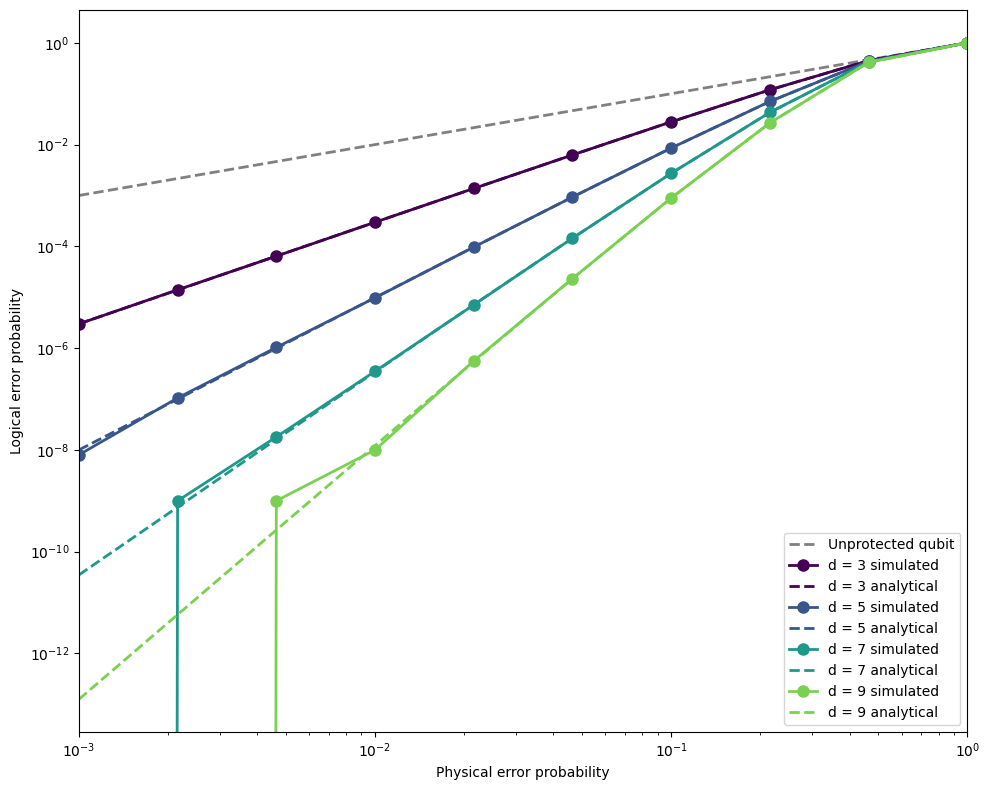

In [12]:
all_analytical_errors = get_logical_error_probability_analytical(distances, physical_errors)
plot_logical_error_probabilities(distances, physical_errors, all_logical_errors, all_analytical_errors)

## <font color='blue'>4. Hints for further speedup</font>

So far, we have sampled all $2\times10^9$ shots from the syndrome table. By reducing the number of circuit executions to just the number of circuits needed to prepare the syndrome table, and sampling from that table repeatedly without running circuits, we have achieved the speedups that we have seen so far.

To motivate additional speedups, it's instructive to look at the generated error patterns that we are looking up in the syndrome table. Below, we demonstrate the error patterns for distance 7, with physical error probability 0.2, and 10 million shots.

In [13]:
def show_error_pattern_distribution(n_qubits, error_probability, n_shots=10_000_000):
    
    # Generate error patterns
    error_patterns = np.random.random((n_shots, n_qubits)) < error_probability
    
    # Count error weights (number of errors in each pattern)
    error_weights = np.sum(error_patterns, axis=1)
    weight_counts = Counter(error_weights)

    # Convert patterns to tuples for counting, 1M at a time
    pattern_list = []
    for pattern in error_patterns[:min(1_000_000, n_shots)]:
        error_locations = tuple(np.where(pattern)[0])
        pattern_list.append(error_locations)
    pattern_counts = Counter(pattern_list)
    
    # Analyze number of unique patterns
    unique_patterns = len(pattern_counts)
    
    # Create figure and axes
    fig, ax1 = plotter.subplots(1,1,figsize=(16, 10))
    
    # Generate all possible patterns for ALL weights
    all_patterns_by_weight = {}
    for weight in range(n_qubits + 1):
        all_patterns_by_weight[weight] = list(combinations(range(n_qubits), weight))
    
    # Create color gradient for weights
    colors = cm.rainbow(np.linspace(0, 1, n_qubits + 1))
    color_map = {i: colors[i] for i in range(n_qubits + 1)}
    
    # Count frequencies for each specific pattern
    pattern_freq_detailed = []
    colors_detailed = []
    
    x_position = 0
    x_positions = []
    weight_boundaries = []
    
    for weight in sorted(all_patterns_by_weight.keys()):
        weight_boundaries.append(x_position)
        for pattern in all_patterns_by_weight[weight]:
            freq = pattern_counts.get(pattern, 0)
            pattern_freq_detailed.append(freq if freq > 0 else 0.1)  # Use 0.1 for log scale visibility
            colors_detailed.append(color_map[weight])
            x_positions.append(x_position)
            x_position += 1
    
    # Calculate bar width based on total number of patterns
    total_patterns = x_position
    bar_width = max(0.1, min(1.0, 800.0 / total_patterns))  # Adaptive width
    
    # Plot bars with thin width
    bars = ax1.bar(x_positions, pattern_freq_detailed, 
                   width=bar_width,
                   color=colors_detailed, 
                   edgecolor='black',  # Remove edges for cleaner look
                   linewidth=0.1)
    
    # Add weight group separators
    for boundary in weight_boundaries[1:]:
        ax1.axvline(x=boundary - 0.5, color='gray', linestyle='-', alpha=0.3, linewidth=0.5)

    ax1.set_xlabel('All possible error patterns (grouped by weight)')
    ax1.set_ylabel('Frequency')
    ax1.set_title(f'Frequency of all {2**n_qubits} possible error patterns in {n_shots} shots')
    ax1.set_yscale('log')
    ax1.set_xlim(-0.5, x_position - 0.5)
    ax1.set_xticks([])
    
    # Add legend for colors
    from matplotlib.patches import Patch
    legend_elements = [Patch(facecolor=color_map[i], label=f'Weight {i}') for i in range(0, n_qubits+1)]
    ax1.legend(handles=legend_elements, loc='upper right', fontsize=8)
    
    # Add grid for easier reading
    ax1.grid(True, alpha=0.2, axis='y')

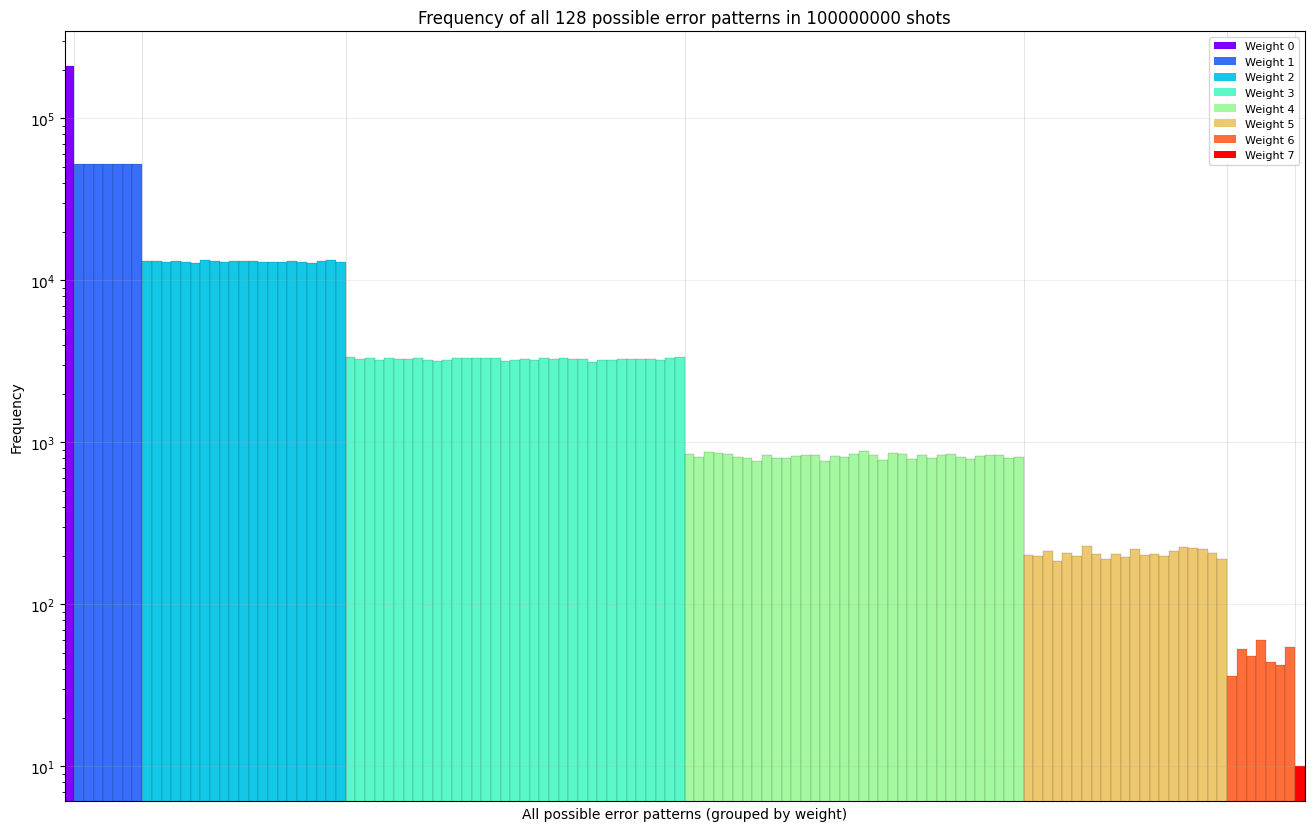

In [14]:
show_error_pattern_distribution(n_qubits = 7, error_probability = 0.2, n_shots = 100_000_000)

As you can see, there is only one way to have weight-0 errors (no errors on all qubits), and that occurs with a frequency of about 200,000 times out of a total of 10 million samples (2%), 7 different ways to have weight-1 errors (one error on each qubit at distance 7), each of which occurs about 50,000 times (0.5%), and so on. 

So far, we have been sampling all error patterns (in the above example, we would have sampled all 10 million error patterns). But as you can see above, there is a significant amount of redundancy in doing so, and grouping should provide significant speedup if we can predetermine the weights of these groupings.

Can you take advantage of this observation to further reduce the simulation time? If so, as you can see above, there is an additional ~10000x to be gained. :)

### Version History

v0: Sep 7, 2025, [github/@aasfaw](https:github.com/aasfaw)